# Notebook to make colloquium figures

In [1]:
%matplotlib inline  

import numpy as np
from numpy.linalg import inv

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Modules needed for Example 1
#from scipy import stats
import emcee
import corner

import scipy.stats as stats  # We'll use stats as our source of pdfs
from scipy.stats import multivariate_normal

In [2]:

def setup_rc_params():
    fontsize = 10
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

    mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
    mpl.rcParams['axes.linewidth']
    mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    mpl.rcParams['xtick.minor.size'] = 2.4
    mpl.rcParams['ytick.minor.size'] = 2.4

    mpl.rcParams['figure.titlesize'] = fontsize

    mpl.rcParams['legend.title_fontsize'] = fontsize
    mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.borderaxespad'] = 0.8
    mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

    mpl.rcParams['hatch.linewidth'] = 0.5

    mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=350, format='png')
    mpl.rcParams['figure.dpi'] = 150



In [3]:
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['figure.dpi'] = 150
# mpl.rcParams['font.family'] = 'serif'
# mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')
setup_rc_params()

color_68 = 'darkgrey'   # color for 1 sigma bands
color_95 = 'lightgrey'  # color for 2 sigma bands


## Distributions

In [4]:
def dist_stuff(dist):
    """
    Finds the median, mean, and 68%/95% credible intervals for the given 
    1-d distribution (which is an object from scipy.stats).  
    """
    # For x = median, mean: return x and the value of the pdf at x as a list
    median = [dist.median(), dist.pdf(dist.median())]  
    mean = [dist.mean(), dist.pdf(dist.mean())]
    # The left and right limits of the credibility interval are returned
    cred68 = dist.interval(0.68)
    cred95 = dist.interval(0.95)
    return median, mean, cred68, cred95

def dist_mode(dist, x):
    """
    Return the mode (maximum) of the 1-d distribution for array x.
    """
    x_max_index = dist.pdf(x).argmax()
    # Return x of the maximum and the value of the pdf at that x 
    mode = [x[x_max_index], dist.pdf(x[x_max_index])]
    return mode

def dist_plot(ax, dist_label, x_dist, dist, color='blue'):
    """
    Plot the distribution, indicating median, mean, mode
    and 68%/95% probability intervals on the axis that is passed.
    """
    median, mean, cred68, cred95 = dist_stuff(dist)
    mode = dist_mode(dist, x_dist)
    
    ax.plot(x_dist, dist.pdf(x_dist), label=dist_label, color=color)    
    ax.set_xlabel('x')
    ax.set_ylabel('p(x)')
    
    # Point to the median, mode, and mean with arrows (adjusting the spacing)
    text_x = 0.2*(x_dist[-1]-x_dist[0])
    text_x_mid = (x_dist[-1]+x_dist[0])/2.
    text_y = mode[1]*1.15
    ax.annotate('median', xy=median, xytext=(text_x_mid+text_x, text_y),
                arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('mode', xy=mode, xytext=(text_x_mid-text_x, text_y),
                arrowprops=dict(facecolor='red', shrink=0.05))
    ax.annotate('mean', xy=mean, xytext=(text_x_mid, text_y),
                arrowprops=dict(facecolor='blue', shrink=0.05))
    
    # Mark the credible intervals using shading (with appropriate alpha)
    ax.fill_between(x_dist, 0, dist.pdf(x_dist), 
                    where=((x_dist > cred68[0]) & (x_dist < cred68[1])), 
                    facecolor='blue', alpha=0.2)
    ax.fill_between(x_dist, 0, dist.pdf(x_dist), 
                    where=((x_dist > cred95[0]) & (x_dist < cred95[1])), 
                    facecolor='blue', alpha=0.1)
    
    ax.legend();


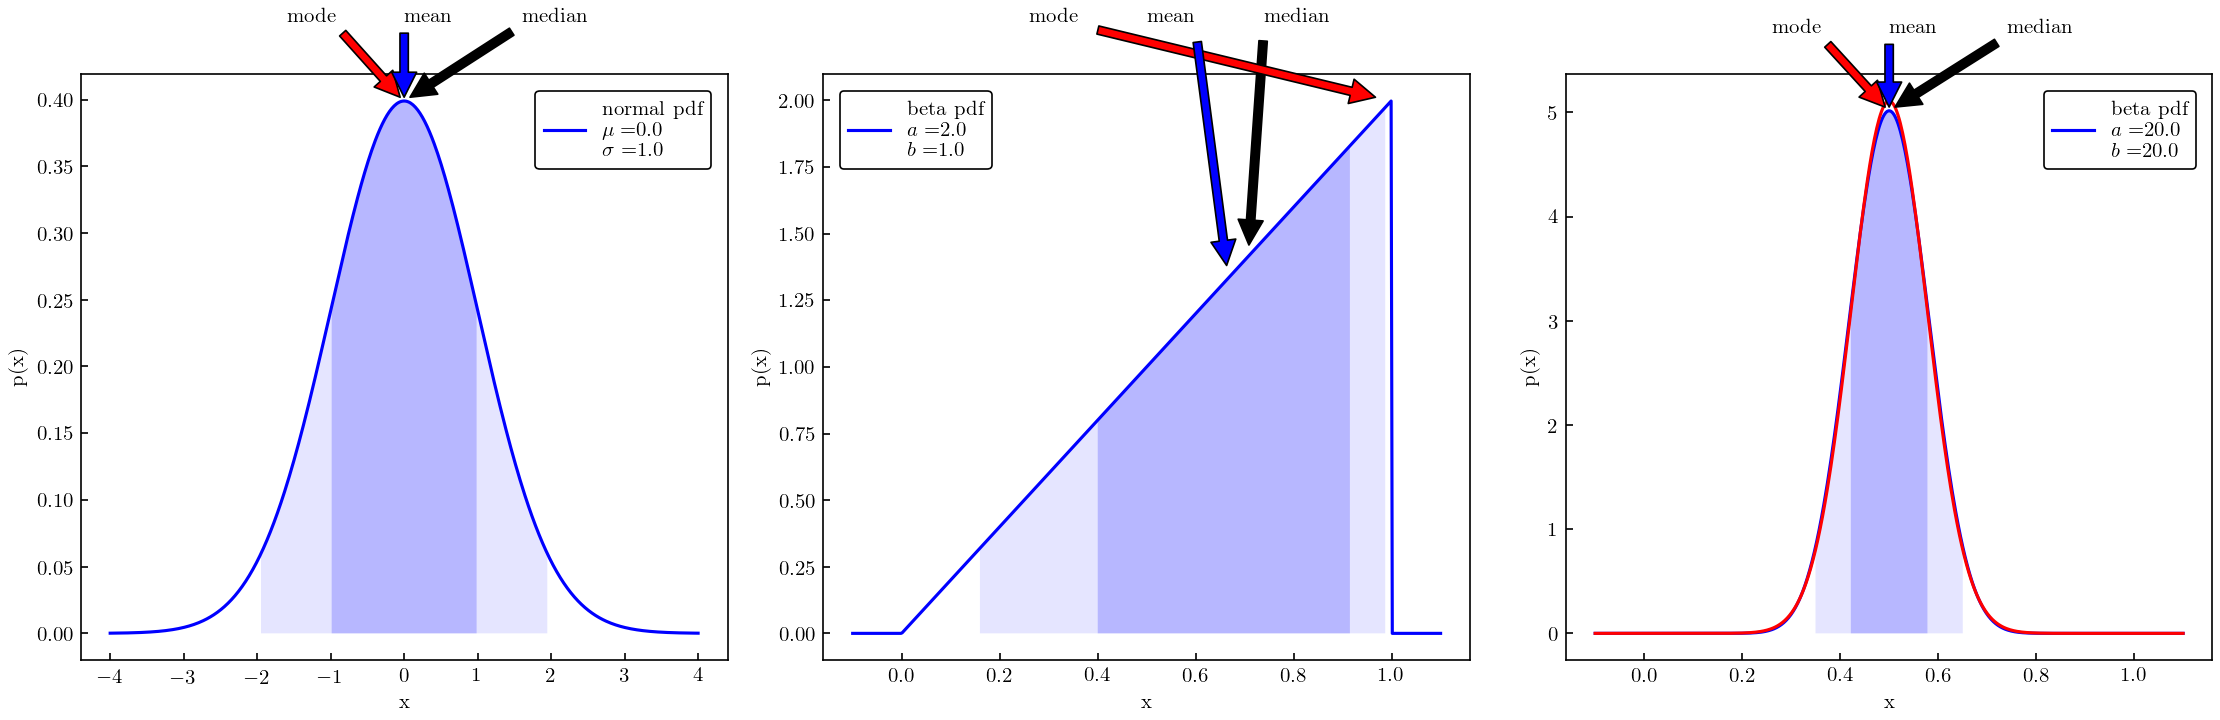

In [5]:
# Make some standard plots: normal, beta
fig = plt.figure(figsize=(15,5))

# Standard normal distribution -- try changing the mean and std. dev. 
x_norm = np.linspace(-4, 4, 500)
mu = 0       # mean
sigma = 1.0  # standard deviation
norm_dist = stats.norm(mu, sigma) # the normal distribution from scipy.stats
norm_label='normal pdf' + '\n' + rf'$\mu=${mu:1.1f}' \
             + '\n' + rf'$\sigma=${sigma:1.1f}' 
ax1 = fig.add_subplot(1,3,1)
dist_plot(ax1, norm_label, x_norm, norm_dist)

# beta distribution, characterized by a and b parameters
x_beta = np.linspace(-0.1, 1.1, 500)  # beta ranges from 0 to 1 
a1 = 2
b1 = 1
beta_dist = stats.beta(a1, b1)  # the beta distribution from scipy.stats
beta1_label='beta pdf' + '\n' + rf'$a=${a1:1.1f}' \
              + '\n' + rf'$b=${b1:1.1f}'
ax2 = fig.add_subplot(1,3,2)
dist_plot(ax2, beta1_label, x_beta, beta_dist)

# another beta distribution
#x_beta = np.linspace(-0.1, 1.1, 500)
a2 = 20
b2 = 20
beta2_dist = stats.beta(a2, b2)
beta2_label='beta pdf' + '\n' + rf'$a=${a2:1.1f}' \
              + '\n' + rf'$b=${b2:1.1f}' 
ax3 = fig.add_subplot(1,3,3)
dist_plot(ax3, beta2_label, x_beta, beta2_dist)

mu2 = beta2_dist.mean()
sigma2 = beta2_dist.std()
norm2_dist = stats.norm(mu2, sigma2)
ax3.plot(x_beta, norm2_dist.pdf(x_beta), color='red')

fig.tight_layout()

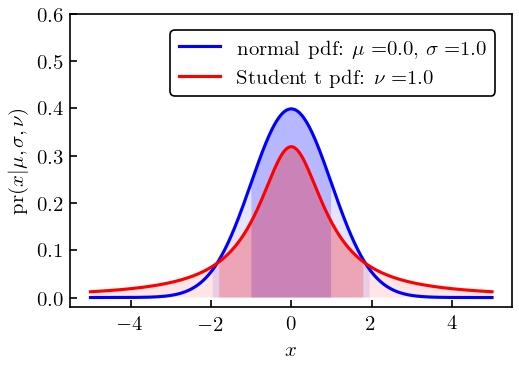

In [6]:

# Make some plots of the Student t distribution
fig = plt.figure(figsize=(3.5,2.5))

x_t = np.linspace(-5, 5, 500)


mu = 0
sigma = 1
norm_label='normal pdf: '  + rf'$\mu=${mu:1.1f}, ' \
              + rf'$\sigma=${sigma:1.1f}' 

nu1 = 1.01
t1_dist = stats.t(nu1) # the Student t distribution
t1_label='Student t pdf: '  + rf'$\nu=${nu1:1.1f}'
cred68 = t1_dist.interval(0.68)
cred95 = t1_dist.interval(0.95)

ax1 = fig.add_subplot(1,1,1)
#dist_plot(ax1, t1_label, x_t, t1_dist)
norm1_dist = stats.norm(mu, sigma)
norm1_cred68 = norm1_dist.interval(0.68)
norm1_cred95 = norm1_dist.interval(0.95)

ax1.plot(x_t, norm1_dist.pdf(x_t), color='blue', label=norm_label)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'${\rm pr}(x | \mu, \sigma, \nu)$')
ax1.legend()
ax1.set_ylim(-.02, 0.6)

fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('distributions_fig1.pdf')

ax1.plot(x_t, t1_dist.pdf(x_t), color='red', label=t1_label)
ax1.legend()

fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('distributions_fig2.pdf')


ax1.fill_between(x_t, 0, norm1_dist.pdf(x_t), 
                    where=((x_t > norm1_cred68[0]) & (x_t < norm1_cred68[1])), 
                    facecolor='blue', alpha=0.2)
ax1.fill_between(x_t, 0, norm1_dist.pdf(x_t), 
                    where=((x_t > norm1_cred95[0]) & (x_t < norm1_cred95[1])), 
                    facecolor='blue', alpha=0.1)

fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('distributions_fig3.pdf')

ax1.fill_between(x_t, 0, t1_dist.pdf(x_t), 
                    where=((x_t > cred68[0]) & (x_t < cred68[1])), 
                    facecolor='red', alpha=0.2)
ax1.fill_between(x_t, 0, t1_dist.pdf(x_t), 
                    where=((x_t > cred95[0]) & (x_t < cred95[1])), 
                    facecolor='red', alpha=0.1)

fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('distributions_fig4.pdf')



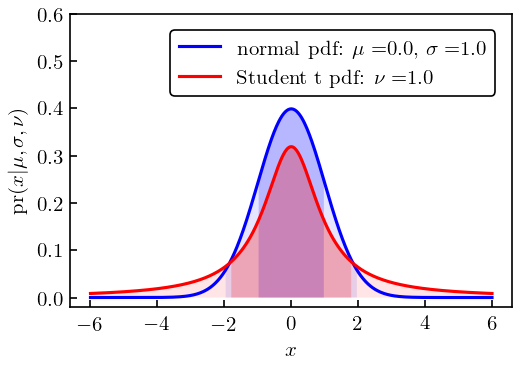

In [7]:

# Make some plots of the Student t distribution
fig = plt.figure(figsize=(3.5,2.5))

x_t = np.linspace(-6, 6, 500)


mu = 0
sigma = 1
norm_label='normal pdf: '  + rf'$\mu=${mu:1.1f}, ' \
              + rf'$\sigma=${sigma:1.1f}' 

nu1 = 1.01
t1_dist = stats.t(nu1) # the Student t distribution
t1_label='Student t pdf: '  + rf'$\nu=${nu1:1.1f}'
cred68 = t1_dist.interval(0.68)
cred95 = t1_dist.interval(0.95)

ax1 = fig.add_subplot(1,1,1)
#dist_plot(ax1, t1_label, x_t, t1_dist)
norm1_dist = stats.norm(mu, sigma)
norm1_cred68 = norm1_dist.interval(0.68)
norm1_cred95 = norm1_dist.interval(0.95)

ax1.plot(x_t, norm1_dist.pdf(x_t), color='blue', label=norm_label)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'${\rm pr}(x | \mu, \sigma, \nu)$')
ax1.legend()
ax1.set_ylim(-.02, 0.6)

fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('distributions_fig1a.pdf')

ax1.plot(x_t, t1_dist.pdf(x_t), color='red', label=t1_label)
ax1.legend()

fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('distributions_fig2a.pdf')


ax1.fill_between(x_t, 0, norm1_dist.pdf(x_t), 
                    where=((x_t > norm1_cred68[0]) & (x_t < norm1_cred68[1])), 
                    facecolor='blue', alpha=0.2)
ax1.fill_between(x_t, 0, norm1_dist.pdf(x_t), 
                    where=((x_t > norm1_cred95[0]) & (x_t < norm1_cred95[1])), 
                    facecolor='blue', alpha=0.1)

fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('distributions_fig3a.pdf')

ax1.fill_between(x_t, 0, t1_dist.pdf(x_t), 
                    where=((x_t > cred68[0]) & (x_t < cred68[1])), 
                    facecolor='red', alpha=0.2)
ax1.fill_between(x_t, 0, t1_dist.pdf(x_t), 
                    where=((x_t > cred95[0]) & (x_t < cred95[1])), 
                    facecolor='red', alpha=0.1)

fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('distributions_fig4a.pdf')



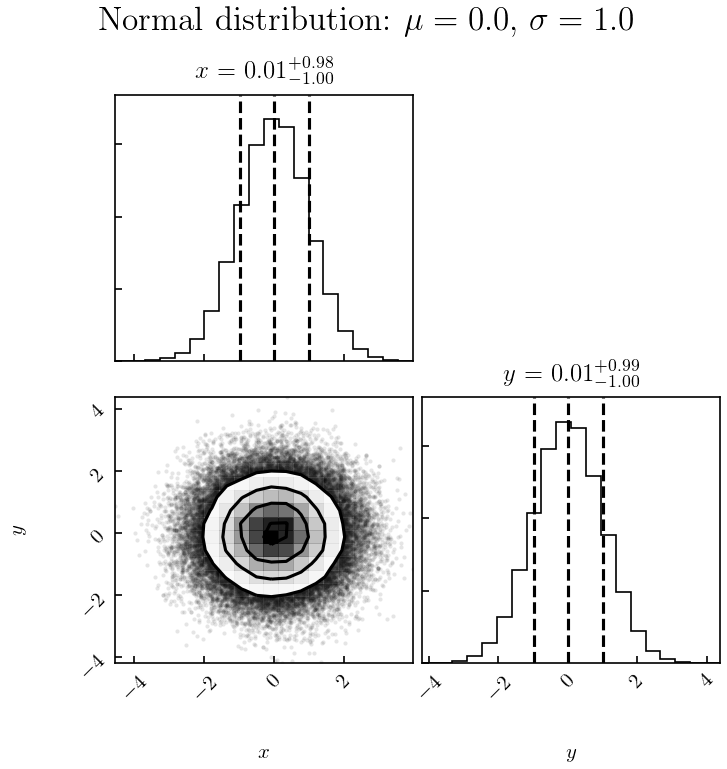

In [8]:
# examples of corner plots
ndim, nsamples = 2, 100000
#np.random.seed(42)
# generate some synthetic data from a normal distribution
mu, sigma = 0., 1.
norm_samples = stats.norm.rvs(size=ndim * nsamples).reshape([nsamples, ndim])

figure1 = corner.corner(norm_samples, 
                        labels=[r"$x$", r"$y$", r"$\log \alpha$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12})
ax = figure1.get_axes()
my_suptitle = rf'Normal distribution: $\mu = {mu:.1f}$, ' + \
              rf'$\sigma = {sigma:.1f}$'
figure1.suptitle(my_suptitle, y=1.0, va='bottom', fontsize=16)
figure1.set_size_inches(5,5)

figure1.tight_layout(w_pad=0.0, h_pad=0.0)
figure1.savefig('distributions_corner_fig1.pdf')


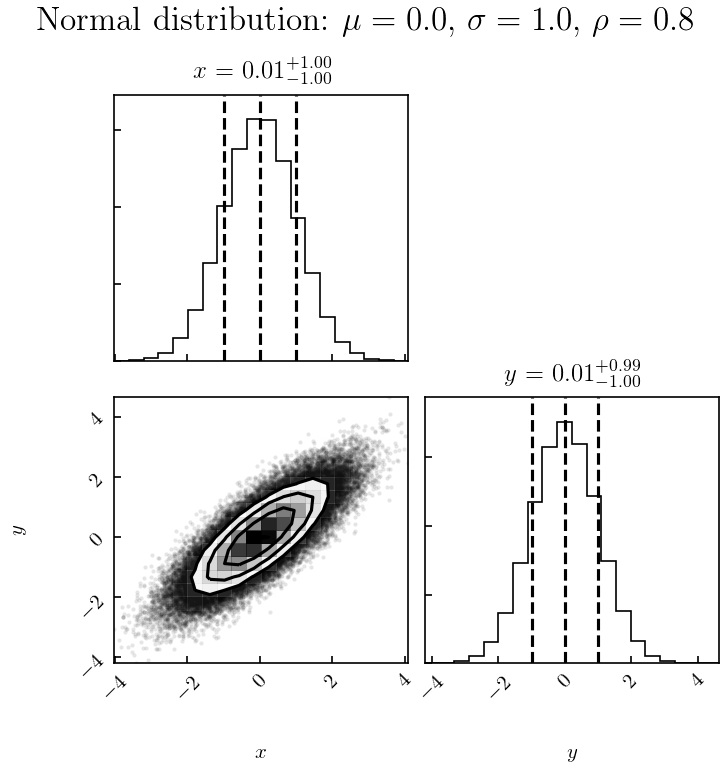

In [9]:
# examples of corner plots
ndim, nsamples = 2, 100000
#np.random.seed(42)
# generate some synthetic data from a normal distribution
mu, sigma = 0., 1.
rho = 0.8
cov_rv = sigma**2 * np.array([[1, rho], [rho, 1]])
rv = multivariate_normal(mean=np.zeros(ndim), cov=cov_rv)

norm_samples = rv.rvs(size=nsamples)

figure1 = corner.corner(norm_samples, 
                        labels=[r"$x$", r"$y$", r"$\log \alpha$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12})
ax = figure1.get_axes()
my_suptitle = rf'Normal distribution: $\mu = {mu:.1f}$, ' + \
              rf'$\sigma = {sigma:.1f}$, ' + \
              rf'$\rho = {rho:.1f}$'
figure1.suptitle(my_suptitle, y=1.0, va='bottom', fontsize=16)
figure1.set_size_inches(5,5)

figure1.tight_layout(w_pad=0.0, h_pad=0.0)
figure1.savefig('distributions_corner_fig1_rho0p8.pdf')


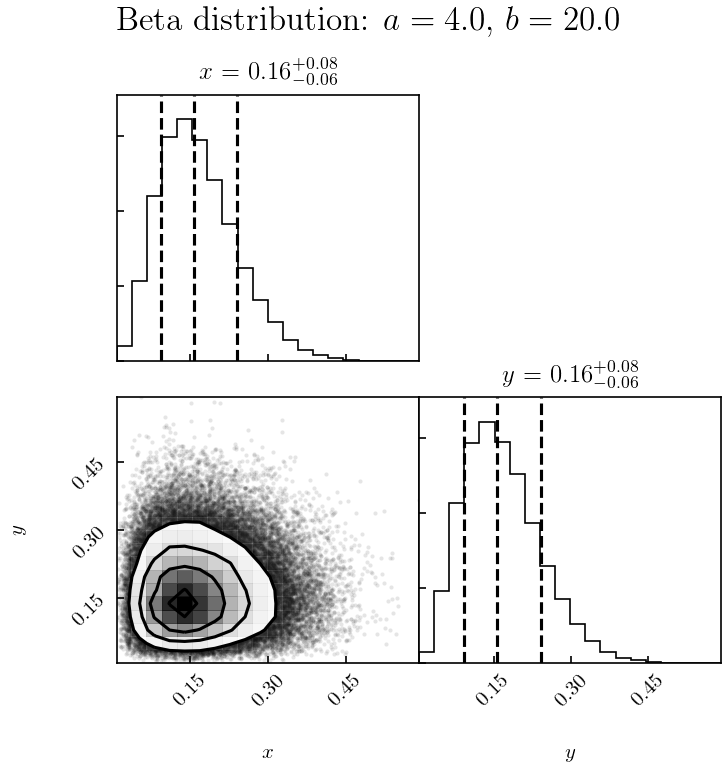

In [10]:
# examples of corner plots

ndim, nsamples = 2, 100000
#np.random.seed(42)
# generate some synthetic data from a beta distribution
a = 4
b = 20
beta_samples = stats.beta(a,b).rvs(size=ndim * nsamples) \
                              .reshape([nsamples, ndim])

figure2 = corner.corner(beta_samples, 
                        labels=[r"$x$", r"$y$", r"$\log \alpha$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12})
my_suptitle = rf'Beta distribution: $a = {a:.1f}$, $b = {b:.1f}$'
figure2.suptitle(my_suptitle, y=1.0, va='bottom', fontsize=16)
figure2.set_size_inches(5,5)

figure2.tight_layout(w_pad=0.0, h_pad=0.0)
figure2.savefig('distributions_corner_fig2.pdf')


## Correlations

$$
\left[
\begin{array}{cc}
  \sigma^2_1 & \rho_{12}\sigma_1\sigma_2 & \rho_{13}\sigma_1\sigma_3 & \rho_{14}\sigma_1\sigma_4 \\
  \rho_{12}\sigma_1\sigma_2 & \sigma^2_2 & \rho_{23}\sigma_2\sigma_3 & \rho_{24}\sigma_2\sigma_4 \\
  \rho_{13}\sigma_1\sigma_3 & \rho_{23}\sigma_2\sigma_3  & \sigma^2_3 & \rho_{34}\sigma_3\sigma_4 \\
  \rho_{14}\sigma_1\sigma_4 & \rho_{24}\sigma_2\sigma_4  & \rho_{34}\sigma_3\sigma_4 & \sigma^2_4 \\ 
\end{array}
\right]
$$

$$\sigma_1 = \sigma_2 = \sigma_3 \equiv \sigma$$

$$\rho_{12} = \rho_{23} = \rho_{34} \equiv \rho$$

$$\rho_{13} = \rho_{24} \equiv \alpha\rho $$

$$\rho_{14} \equiv \beta\rho $$

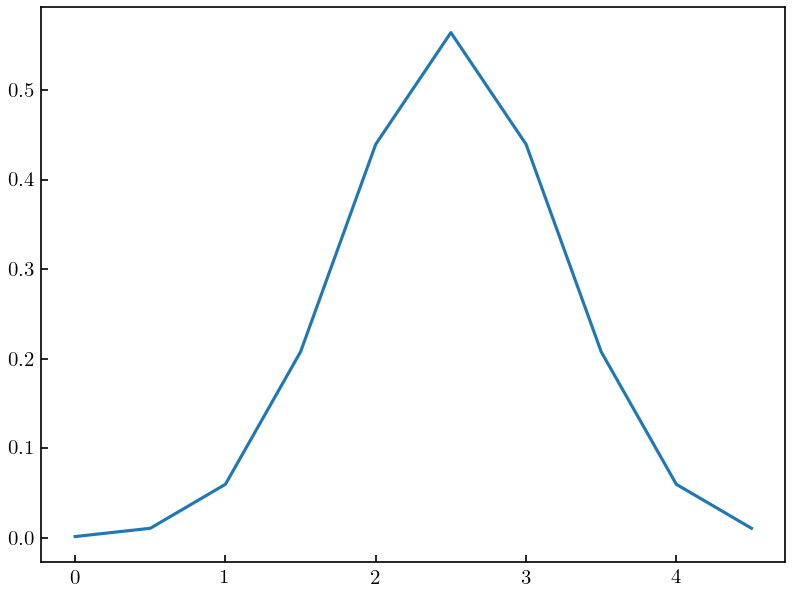

In [11]:
x = np.linspace(0, 5, 10, endpoint=False)
y = multivariate_normal.pdf(x, mean=2.5, cov=0.5); y
np.array([ 0.00108914,  0.01033349,  0.05946514,  0.20755375,  0.43939129,
        0.56418958,  0.43939129,  0.20755375,  0.05946514,  0.01033349])
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.plot(x, y)

In [12]:
# def y_true(x):
#     """
#     Function representing the true observable
#     """
#     #return np.sin(x)
#     return np.zeros(len(x))

# x, y = np.mgrid[-1:1:.01, -1:1:.01]
# pos = np.dstack((x, y))
# sig1 = 0.2
# sig2 = 0.2
# sig3 = 0.2
# sig4 = 0.2
# rho12 = rho21 = 0.7
# rho13 = rho31 = 0.1
# rho14 = rho41 = 0.0
# rho23 = rho32 = 0.7
# rho24 = rho42 = 0.1
# rho34 = rho43 = 0.7

# Sigma_th = [
#     [sig1**2, rho12 * sig1 * sig2, rho13 * sig1 * sig3, rho14 * sig1 * sig4],
#     [rho21 * sig2 * sig1, sig2**2, rho23 * sig2 * sig3, rho24 * sig2 * sig4],
#     [rho31 * sig3 * sig1, rho32 * sig3 * sig2, sig3**2, rho34 * sig3 * sig4],
#     [rho41 * sig4 * sig1, rho42 * sig4 * sig2, rho43 * sig4 * sig3, sig4**2],
#            ]
# # fig2 = plt.figure()
# # ax2 = fig2.add_subplot(111)
# # ax2.contourf(x, y, rv.pdf(pos))
# # ax2.set_aspect(1)

# # fig2.tight_layout(w_pad=0.0, h_pad=0.0)

# x_full_min = 0.
# x_full_max = np.pi/2.
# x_full_pts = np.linspace(x_full_min, x_full_max, 200)
# y_true_full_pts = y_true(x_full_pts)

# x_min = 1.
# x_max = 2.
# num_x = 4
# x_pts = np.linspace(x_full_min, x_full_max, num_x + 2)[1:-1]

# rv = multivariate_normal(mean=np.zeros(num_x), cov=Sigma_th)


# num_plts = 4

# y_true_pts = y_true(x_pts)
# y_error_pts = rv.rvs(size=num_plts)
# y_pts = y_true_pts + y_error_pts


# fig3, axes = plt.subplots(num_plts, 1, sharex=True, sharey=True, figsize=(6,6))
# for i in np.arange(num_plts):
#     axes[i].plot(x_full_pts, y_true_full_pts, color='blue')
#     axes[i].errorbar(x_pts, y_pts[i,:], [sig1, sig2, sig3, sig4], 
#                      fmt='o', color='red', capsize=10)
#     axes[i].set_ylim([-0.75, 0.75])
#     #axes[i].tick_params('y', right=True, labelsize=0, length=0)
#     #axes[i].tick_params('x', labelsize=0, length=0)
#     axes[i].tick_params('y', labelsize=0)
#     axes[i].tick_params('x', labelsize=0)
# #fig3.tight_layout()
# fig3.tight_layout(w_pad=0.0, h_pad=0.0)


## Gaussian processes

In [13]:
import GPy

In [14]:
d = 1 # input dimension
var = 1. # variance
theta = 0.2 # lengthscale
k = GPy.kern.RBF(d,var,theta)

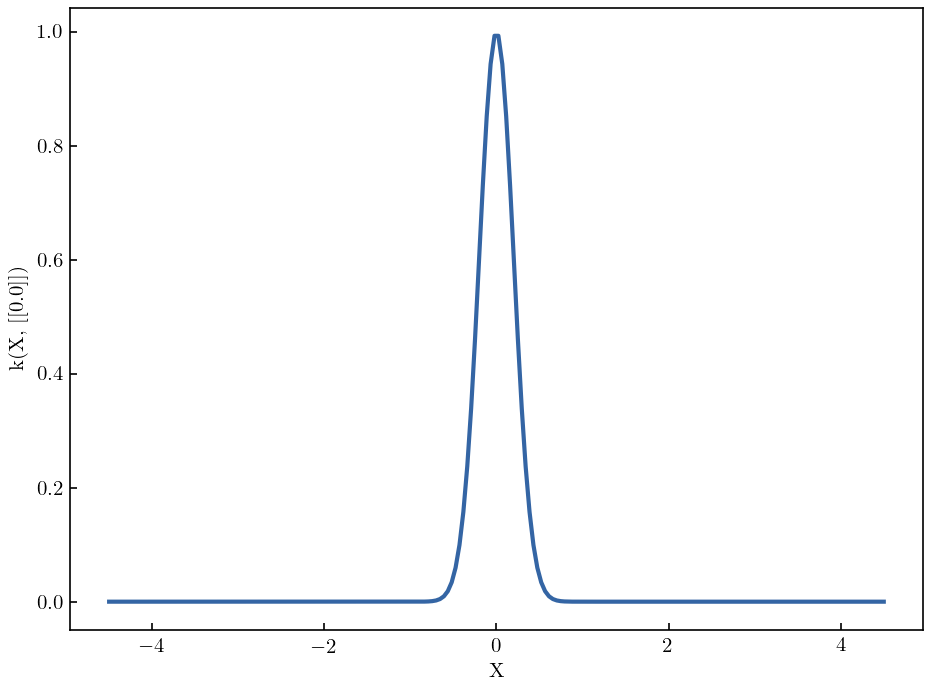

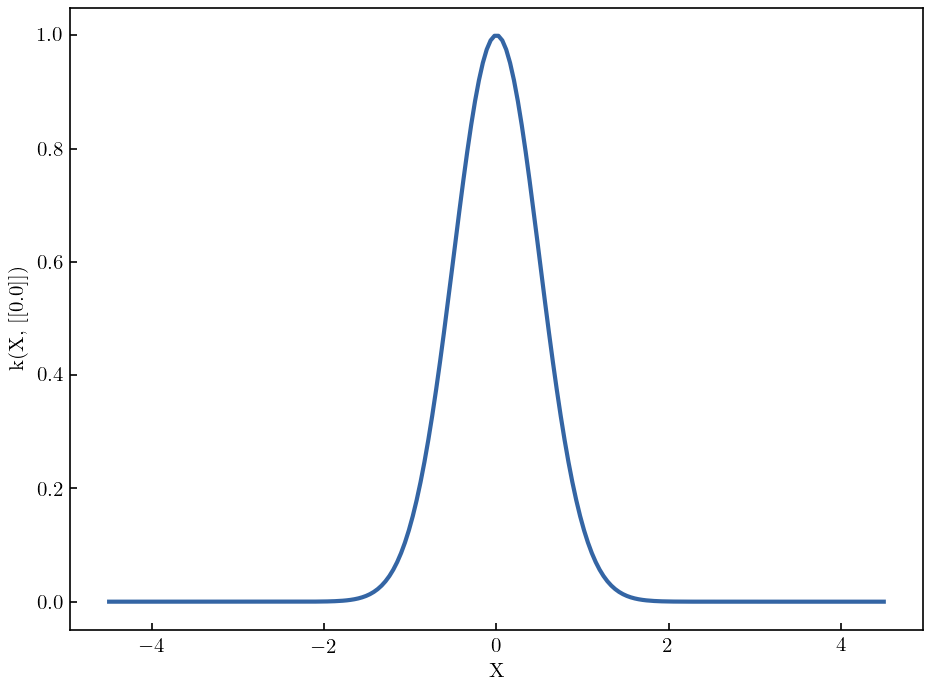

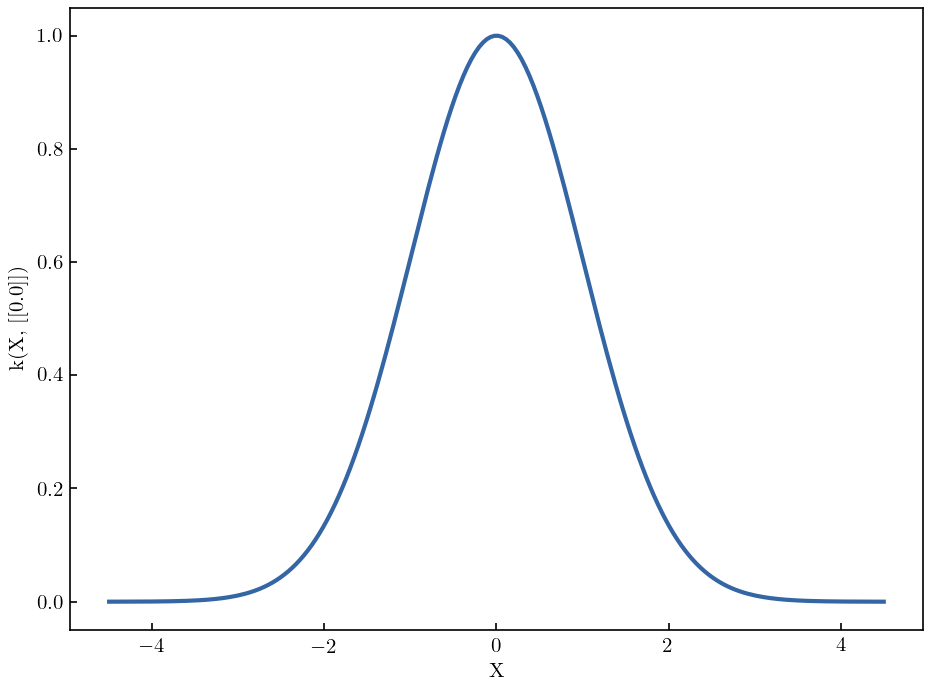

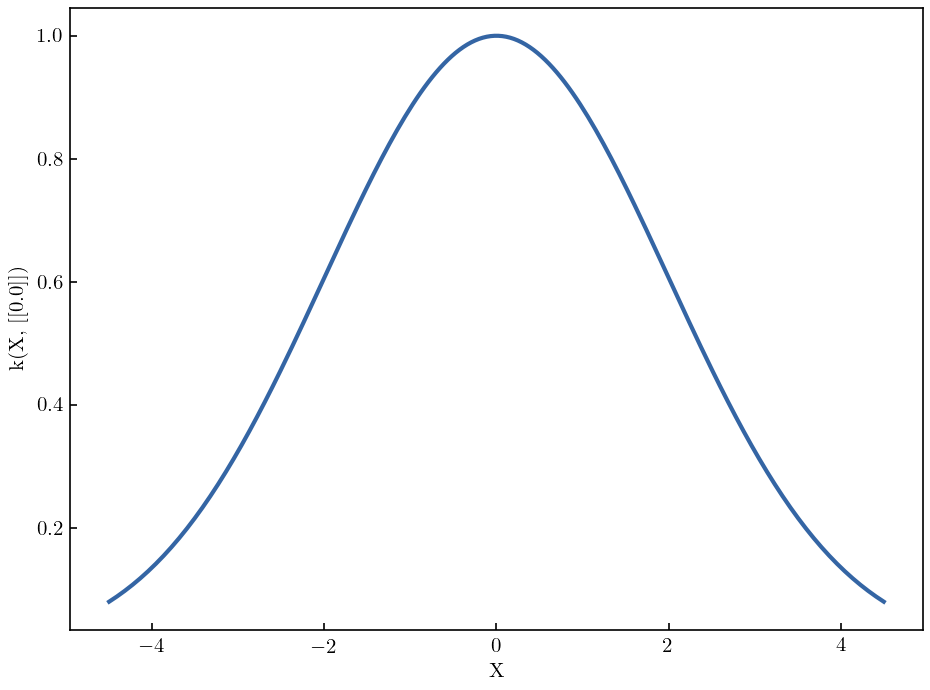

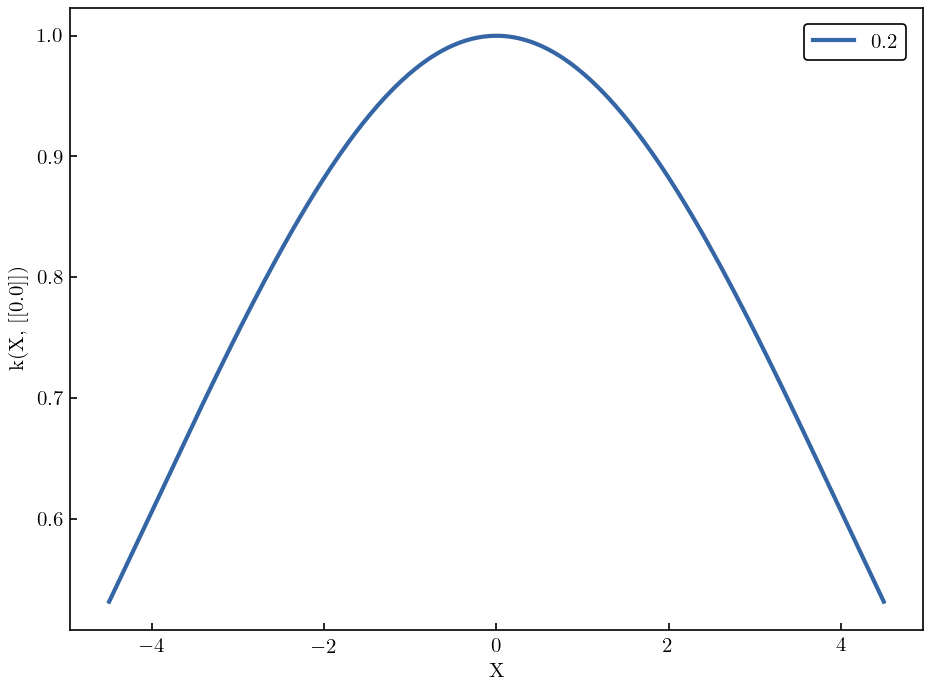

In [15]:
k = GPy.kern.RBF(d) # By default, the parameters are set to 1.
theta = np.asarray([0.2,0.5,1.,2.,4.])
for t in theta:
    k['.*lengthscale']=t
    k.plot()
plt.legend(theta)

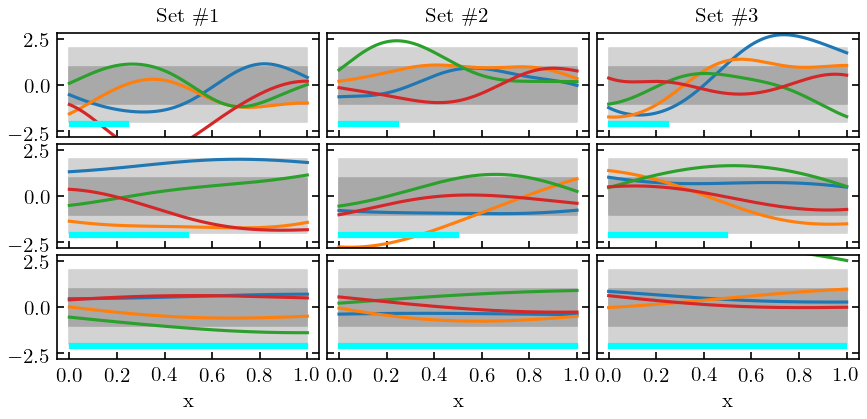

In [16]:
xmin = 0.; xmax = 1.
n_pts = 500
X = np.linspace(xmin, xmax, n_pts) # n_pts points evenly spaced over [xmin,xmax]
X = X[:,None] # reshape X to make it n*D
mu = np.zeros((n_pts)) # vector of the means
std = 1.

ls_list = [0.25, 0.5, 1.0]

fig, axes = plt.subplots(3, 3, figsize=(6,3), sharey=True, sharex=True) 
for i, lengthscale in enumerate(ls_list):
    k = GPy.kern.RBF(input_dim=1, lengthscale=lengthscale)
    C = k.K(X,X) # covariance matrix
    # Generate 4 sample path with mean mu and covariance C
    for num in range(3):
        Z = np.random.multivariate_normal(mu,C,4)
        axes[i, num].fill_between(X.flatten(), 
                                  mu.flatten() + 2*std, mu.flatten() - 2*std, 
                                  color=color_95)
        axes[i, num].fill_between(X.flatten(), 
                                  mu.flatten() + std, mu.flatten() - std, 
                                  color=color_68)

        for j in range(4):
            axes[i, num].plot(X[:],Z[j,:])
        axes[i, num].tick_params('y', right=True)
        axes[i, num].set_xlim(-.05, 1.05) 
        axes[i, num].set_ylim(-2.8, 2.8)
#        axes[i, num].set_xticks(np.arange(0, 1.01, step=0.2))
        axes[i, num].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        if i == 0:
            axes[i, num].set_title(f'Set \#{num+1}')
        if i == len(ls_list) - 1:
            axes[i, num].set_xlabel(r'x')
        linewidth = 3
        delta_x = .01
        axes[i, num].plot((0+delta_x, lengthscale-delta_x), (-2.1, -2.1), 
                          color='cyan', lw=linewidth)    
fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('gp_draws_different_ls.pdf')

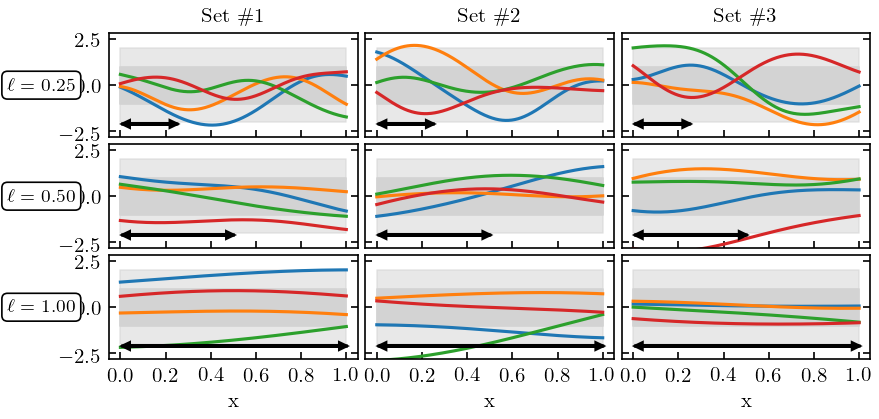

In [17]:
color_68 = 'darkgrey'   # color for 1 sigma bands
color_95 = 'lightgrey'  # color for 2 sigma bands

xmin = 0.; xmax = 1.
n_pts = 500
X = np.linspace(xmin, xmax, n_pts) # n_pts points evenly spaced over [xmin,xmax]
X = X[:,None] # reshape X to make it n*D
mu = np.zeros((n_pts)) # vector of the means
std = 1.

ls_list = [0.25, 0.5, 1.0]

fig, axes = plt.subplots(3, 3, figsize=(6,3), sharey=True, sharex=True) 
for i, lengthscale in enumerate(ls_list):
    k = GPy.kern.RBF(input_dim=1, lengthscale=lengthscale)
    C = k.K(X,X) # covariance matrix
    # Generate 4 sample path with mean mu and covariance C
    axes[i, 0].text(-0.35, 0.0, fr'$\ell = {lengthscale:.2f}$', size=9, 
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='white',
                   )
         )
    for num in range(3):
        Z = np.random.multivariate_normal(mu,C,4)
        axes[i, num].fill_between(X.flatten(), 
                                  mu.flatten() + 2*std, mu.flatten() - 2*std, 
                                  color=color_95, alpha=0.5)
        axes[i, num].fill_between(X.flatten(), 
                                  mu.flatten() + std, mu.flatten() - std, 
                                  color=color_95)

        for j in range(4):
            axes[i, num].plot(X[:],Z[j,:])
        axes[i, num].tick_params('y', right=True)
        axes[i, num].set_xlim(-.05, 1.05) 
        axes[i, num].set_ylim(-2.8, 2.8)
#        axes[i, num].set_xticks(np.arange(0, 1.01, step=0.2))
        axes[i, num].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        if i == 0:
            axes[i, num].set_title(f'Set \#{num+1}')
        if i == len(ls_list) - 1:
            axes[i, num].set_xlabel(r'x')
        linewidth = 3
        delta_x = .01

        axes[i, num].arrow(0+delta_x, -2.1, lengthscale-delta_x, 0., 
                           color='black', lw=linewidth/2,
                           head_width=0.35, head_length=0.03, 
                           length_includes_head=True, zorder=10)    
        axes[i, num].arrow(lengthscale, -2.1, -lengthscale+delta_x, 0., 
                           color='black', lw=linewidth/2,
                           head_width=0.35, head_length=0.03, 
                           length_includes_head=True, zorder=10)    
fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('gp_draws_different_ls.pdf')

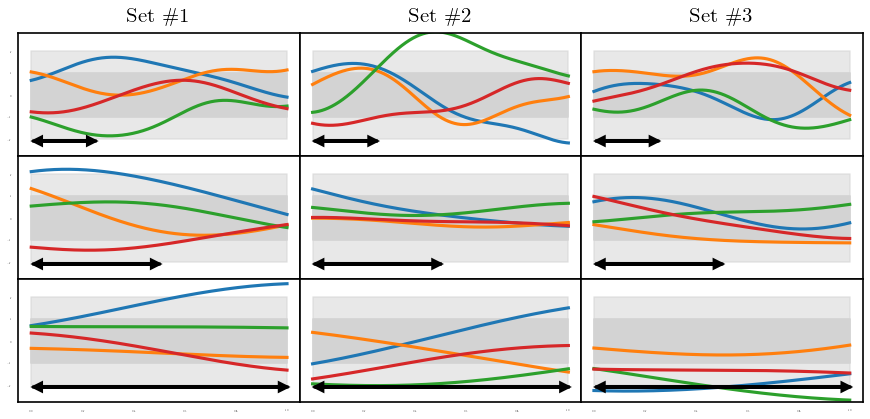

In [18]:
color_68 = 'darkgrey'   # color for 1 sigma bands
color_95 = 'lightgrey'  # color for 2 sigma bands

xmin = 0.; xmax = 1.
n_pts = 500
X = np.linspace(xmin, xmax, n_pts) # n_pts points evenly spaced over [xmin,xmax]
X = X[:,None] # reshape X to make it n*D
mu = np.zeros((n_pts)) # vector of the means
std = 1.

ls_list = [0.25, 0.5, 1.0]

fig, axes = plt.subplots(3, 3, figsize=(6,3), sharey=True, sharex=True) 
for i, lengthscale in enumerate(ls_list):
    k = GPy.kern.RBF(input_dim=1, lengthscale=lengthscale)
    C = k.K(X,X) # covariance matrix
    # Generate 4 sample path with mean mu and covariance C
#     axes[i, 0].text(-0.35, 0.0, fr'$\ell = {lengthscale:.2f}$', size=9, 
#          ha="center", va="center",
#          bbox=dict(boxstyle="round",
#                    ec='black',
#                    fc='white',
#                    )
#          )
    for num in range(3):
        Z = np.random.multivariate_normal(mu,C,4)
        axes[i, num].fill_between(X.flatten(), 
                                  mu.flatten() + 2*std, mu.flatten() - 2*std, 
                                  color=color_95, alpha=0.5)
        axes[i, num].fill_between(X.flatten(), 
                                  mu.flatten() + std, mu.flatten() - std, 
                                  color=color_95)

        for j in range(4):
            axes[i, num].plot(X[:],Z[j,:])
        axes[i, num].tick_params('y', right=True, labelsize=0, length=0)
        axes[i, num].tick_params('x', labelsize=0, length=0)
        axes[i, num].set_xlim(-.05, 1.05) 
        axes[i, num].set_ylim(-2.8, 2.8)
#        axes[i, num].set_xticks(np.arange(0, 1.01, step=0.2))
        axes[i, num].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        if i == 0:
            axes[i, num].set_title(f'Set \#{num+1}')
        #if i == len(ls_list) - 1:
            #axes[i, num].set_xlabel(r'x')
        linewidth = 3
        delta_x = .01

        axes[i, num].arrow(0+delta_x, -2.1, lengthscale-delta_x, 0., 
                           color='black', lw=linewidth/2,
                           head_width=0.35, head_length=0.03, 
                           length_includes_head=True, zorder=10)    
        axes[i, num].arrow(lengthscale, -2.1, -lengthscale+delta_x, 0., 
                           color='black', lw=linewidth/2,
                           head_width=0.35, head_length=0.03, 
                           length_includes_head=True, zorder=10)    
fig.tight_layout(w_pad=0.0, h_pad=0.0)
fig.savefig('gp_draws_different_ls_plain.pdf')